<a href="https://colab.research.google.com/github/QAPhy/QAPhy.github.io/blob/master/AIPND_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing All The dependencies for you project

In [0]:
%matplotlib inline

In [0]:

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import time
import os
import copy
import pillow 

plt.ion()   # interactive mode

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Loading Your Data for preparing 

In [0]:


# TODO: Define transforms for the training data and testing data
#transforms.RandomRotation(30),
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Pass transforms in here, then run the next cell to see how the transforms look
data_dir = 'drive/My Drive/Colab Notebooks/car_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
!pip install pil

/bin/bash: conda: command not found


### Visualizing Your Data ( Classes and Labels) to check the validity of preparing data

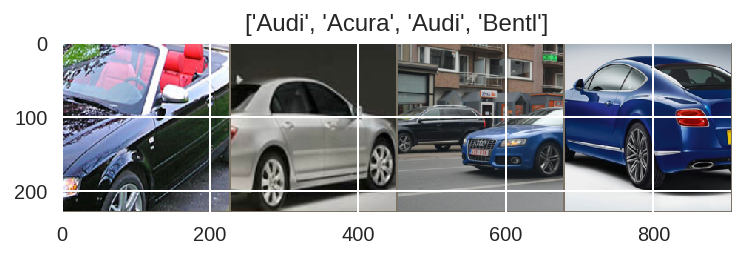

In [4]:
# this fuction cited from Pytorch.org
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Generate Function for Training your model 

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Generate Function to visualize prediction of set of images

In [0]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Load a pretrained model and reset final fully connected layer.

In [0]:
model_ft = models.resnet18(pretrained=True)
model_ft
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4) #set the features of fully connected layer and number of classes (in this project = 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

In [8]:
# using the pretrained model to training your data by using the train_model function 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1057 Acc: 0.5666
val Loss: 0.9822 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.9205 Acc: 0.6755
val Loss: 0.8413 Acc: 0.7955

Epoch 2/24
----------
train Loss: 0.7699 Acc: 0.7121
val Loss: 0.7491 Acc: 0.7727

Epoch 3/24
----------
train Loss: 0.7475 Acc: 0.7263
val Loss: 1.0080 Acc: 0.7955

Epoch 4/24
----------
train Loss: 0.7166 Acc: 0.7363
val Loss: 1.1617 Acc: 0.8636

Epoch 5/24
----------
train Loss: 0.5654 Acc: 0.7962
val Loss: 0.9986 Acc: 0.8409

Epoch 6/24
----------
train Loss: 0.5638 Acc: 0.7862
val Loss: 0.9565 Acc: 0.7955

Epoch 7/24
----------
train Loss: 0.4261 Acc: 0.8478
val Loss: 0.9817 Acc: 0.8409

Epoch 8/24
----------
train Loss: 0.3655 Acc: 0.8735
val Loss: 1.1932 Acc: 0.8636

Epoch 9/24
----------
train Loss: 0.3324 Acc: 0.8877
val Loss: 1.0445 Acc: 0.8636

Epoch 10/24
----------
train Loss: 0.3314 Acc: 0.8852
val Loss: 1.1379 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.3169 Acc: 0.8960
val Loss: 0.9772 Acc: 0.8636

Ep

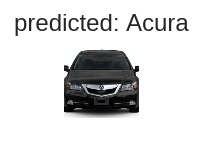

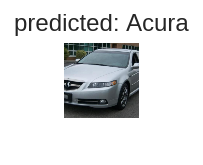

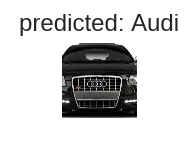

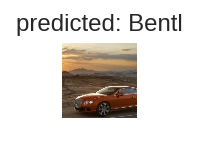

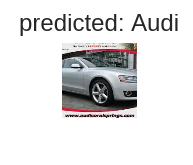

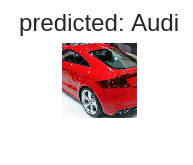

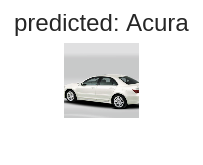

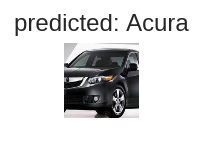

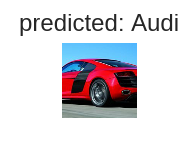

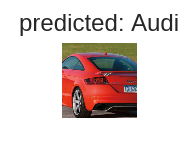

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd34767eef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [9]:
# visualize the validation for set of images 
visualize_model(model_ft)

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer (classifier): Linear(in_features=1024, out_features=1000). This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate by replacing the classifier parameter of the model

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=9)

Epoch 0/8
----------
train Loss: 1.2938 Acc: 0.4700
val Loss: 0.9468 Acc: 0.6364

Epoch 1/8
----------
train Loss: 1.0573 Acc: 0.5707
val Loss: 1.0256 Acc: 0.6364

Epoch 2/8
----------
train Loss: 0.9965 Acc: 0.6273
val Loss: 1.3481 Acc: 0.6136

Epoch 3/8
----------
train Loss: 0.9886 Acc: 0.5982
val Loss: 1.2318 Acc: 0.6818

Epoch 4/8
----------
train Loss: 1.0106 Acc: 0.6057
val Loss: 1.5724 Acc: 0.6364

Epoch 5/8
----------
train Loss: 1.0519 Acc: 0.5940
val Loss: 1.4702 Acc: 0.6364

Epoch 6/8
----------
train Loss: 0.9679 Acc: 0.6131
val Loss: 1.1590 Acc: 0.6591

Epoch 7/8
----------
train Loss: 0.8470 Acc: 0.6681
val Loss: 1.0279 Acc: 0.6818

Epoch 8/8
----------
train Loss: 0.8016 Acc: 0.6764
val Loss: 1.1345 Acc: 0.7273

Training complete in 29m 49s
Best val Acc: 0.727273


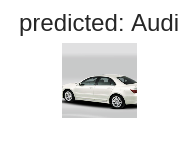

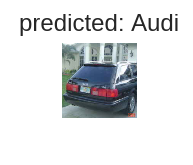

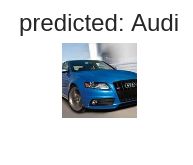

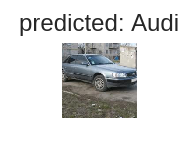

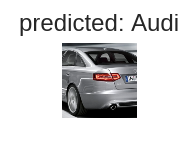

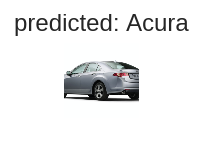

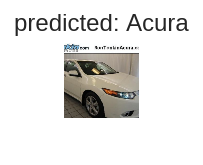

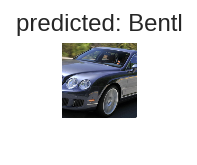

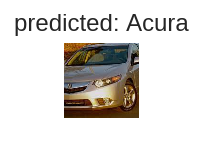

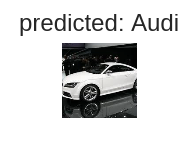

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [31]:
print("Our model: \n\n", model_ft, '\n')
print("The state dict keys: \n\n", model_ft.state_dict().keys())

Our model: 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
   

In [0]:
# saving your model
torch.save(model_ft.state_dict(), 'checkpoint.pth')

In [35]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())
model_ft.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [0]:
def check_accuracy_on_test(dataloaders):    
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            print(preds,labels)
           
        
    print('Accuracy of the network on the 44 test images: %d %%' % (100 * correct / total))
    
    

In [59]:
#Test your model
check_accuracy_on_test(dataloaders)

tensor([2, 2, 3, 3]) tensor([2, 2, 3, 3])
tensor([2, 0, 3, 2]) tensor([1, 0, 3, 2])
tensor([2, 3, 1, 0]) tensor([1, 3, 1, 0])
tensor([1, 3, 3, 1]) tensor([1, 3, 3, 1])
tensor([2, 0, 0, 3]) tensor([2, 0, 0, 3])
tensor([1, 2, 2, 0]) tensor([1, 2, 2, 0])
tensor([3, 0, 2, 2]) tensor([3, 0, 1, 2])
tensor([0, 1, 3, 0]) tensor([0, 1, 3, 0])
tensor([3, 0, 2, 2]) tensor([3, 0, 1, 1])
tensor([2, 1, 3, 0]) tensor([2, 1, 3, 2])
tensor([2, 2, 0, 0]) tensor([2, 2, 0, 0])
Accuracy of the network on the 44 test images: 86 %


AttributeError: ignored